In [ ]:
import numpy as np
import math
import random
from scipy import stats
import sys
import os


############################ ENVIRONMENT TYPE ################################
##RandomWalk##

class ComponentwiseRandomWalk:
    """
        Variable-step component-wise random walk model of the environment. Evolution of the true state.
        Arguments:
            * n = dimension of state
            * p = probability of taking a nonzero step
            * [d_underbar, d_overbar] = the bounds of the uniform random variable stepsize
    """
    def __init__(self, n, p, d_underbar, d_overbar):
        self.n = n
        self.p = p
        self.d_underbar =d_underbar
        self.d_overbar = d_overbar


    def get_next_state(self,current_state):
        RanMat = np.zeros((self.n,1))
        for i in range(self.n):
            p1 = random.uniform(0,1)
            if((self.p/2)>p1):
                RanMat[i] = random.uniform(self.d_underbar,self.d_overbar)
            elif(self.p>p1):
                RanMat[i] = random.uniform(-self.d_overbar,-self.d_underbar)
            else:
                RanMat[i] = 0
        self.RanMat = RanMat
        return (current_state + RanMat)


############################ PARTS OF THE MODULAR FRAMEWORK ################################

class CentralUnit:
    """
        Central Processor class.
        No memory (Hc = 1).
        Arguments:
            * init_estimate = central unit's initial estimate hat{X}_C
    """
    def __init__(self, init_estimate, M , weighted_sum):
        """
            random.uniform[-2,2]
            TODO. ALSO, FEEL FREE TO ADD MORE ARGUMENTS AS YOU SEE FIT.
        """
        self.estimate = init_estimate
        self.previous_estimate = init_estimate
        self.weighted_sum= weighted_sum
        self.M=M
        self.time_saved = 0

        for i in range(M):
            if i == 0 :
                self.processor_table=  np.array([init_estimate])
            else:
                self.processor_table = np.append(self.processor_table,[init_estimate],axis=0)





    def get_broadcast(self):
        return self.estimate


    def get_fusion(self,trigger_value,i):

        self.previous_estimate = self.estimate

        self.estimate=self.estimate-np.array(self.weighted_sum[i]@self.processor_table[i])

        self.processor_table[i] =  trigger_value

        self.estimate=self.estimate+np.array(self.weighted_sum[i]@self.processor_table[i])

        return self.estimate



class Sensor:

    """
        Sensor class.
        No memory. Transmits most recent update.
        Arguments:
            * id = sensor ID (j)
            * sigma = white noise variance
            * C = nxn diagonal observation matrix (equation y = C(x + w))
            * components = the mathcal{C} set of {1...n} measured by sensor, i.e. the set of i where C(i,i)=1 measure 차원
    """
    def __init__(self, id, sigma, C, components,x):

        self.id = id
        self.sigma = sigma
        self.C  = C
        self.components = components
        self.n = len(C)
        self.obsv_value = x
        self.prev_obsv_value = x
        self.broadcast_value = x
        self.triggering_mat = x
        self.triggering_state = 0
        self.time_saved = 0
        self.time_saved2 = 0
        self.number_packets = 0



    def get_obsv(self,current_state):
        white_noise = np.random.normal(0,self.sigma,(len(current_state),1))
        obsv_value= self.C@(current_state+white_noise)

        return obsv_value

    def receive_obsv(self,obsv):
        self.prev_obsv_value = self.obsv_value
        self.obsv_value = obsv
        return

    def nf_triggering(self, eps):

        self.number_packets = 0



        for i in range(len(self.prev_obsv_value)):
            if self.obsv_value[i] != 0:
                if((abs(self.prev_obsv_value[i]-self.obsv_value[i]))>eps):
                    self.triggering_mat[i]=self.obsv_value[i]
                    self.number_packets+= 1

        return self.number_packets



    def fb_triggering(self, eps):


        self.number_packets = 0
        for i in range(len(self.broadcast_value)):
            if self.obsv_value[i] != 0 :
                if((abs(self.broadcast_value[i]-self.obsv_value[i]))>eps):
                    self.triggering_mat[i]=self.obsv_value[i]
                    self.number_packets+= 1

        return self.number_packets


    def receive_broadvalue(self,broadvalue):
        self.broadcast_value = broadvalue
        return

    def get_broadvalue(self):
        return self.broadcast_value




############################ PERFORMANCE METRICS ################################

def get_mse(real,estimate):
    mse = ((real- estimate)**2).sum()
    return mse



In [ ]:
! sudo apt-get install texlive-latex-recommended
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-urw-base35
  libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libkpathsea6 libptexenc1 libsynctex2 libteckit0 libtexlua53 libtexluajit2
  libwoff1 libzzip-0-13 lmodern poppler-data t1utils tex-common texlive-base
  texlive-binaries texlive-latex-base xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  poppler-utils ghostscript fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum debhelper gv | postscript-viewer perl-tk xpdf
  | pdf-viewer xzdec texlive-latex-base-doc texlive-latex-recommended-doc
  texlive-luatex texlive-pstricks
The following NEW packages will be installed:
  dvisvgm fonts-droid-fa

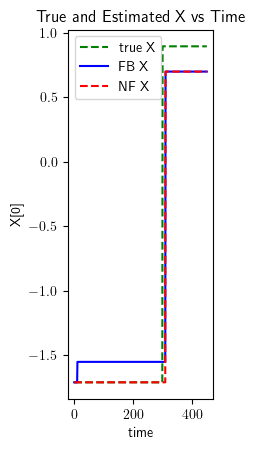

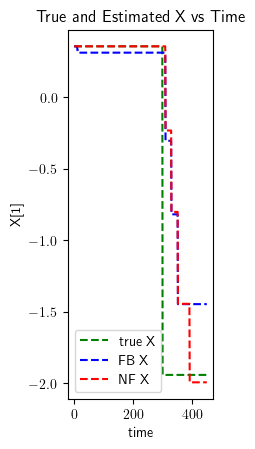

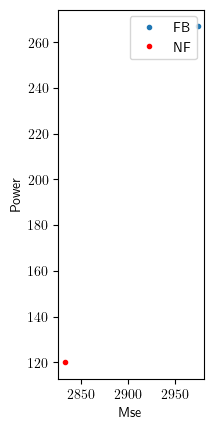

In [ ]:
import numpy as np
import math
import random
import os
from random import randrange
import sys
from itertools import combinations
%matplotlib notebook
%matplotlib inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True

import matplotlib.pyplot as plt

##from classes import *

############################### INITIALIZATIONS ######################################

#### ENVIRONMENT
n = 10 # dimension of the true state
d_underbar = 2.0; d_overbar = 4.0 # step size distribution such that d~U[d_underbar,d_overbar]
p = 0.8 # probability of a single component taking a nonzero step
Delta_t = 300.0 # baseline period of switching
env = ComponentwiseRandomWalk(n, p, d_underbar, d_overbar)
X0 = np.random.uniform(-2, 2, size=(n,1)) # initial true state


#### COMMUNICATION DELAYS AND RATE OF POWER PER COMPONENT

DeltaT_u = 2.0 # amount of delay spent transmitting uplink from sensor to central processor (per packet)
DeltaT_d = 1.0 # amount of delay spent broadcasting downlink throughout sensors (entire broadcast)
uplink_rate = 4.0 # rate of power per packet expended by each sensor while transmitting uplink information
downlink_rate = 1.0 # rate of power per packet expended by each sensor while receiving downlink information


#### SENSOR COMPONENTS, SAMPLING PERIODS, AND OFFSETS
M = 5 # number of sensors
# plot_sensor_choice = [0,1]
sigma = 0.2 # white noise variance (same for all sensors)
tau = 100.0 # sampling period for all sensors
weight_matrix=[np.eye(n)]


all_sensor_params = {}
for j in range(M):
    b_j = 20*j # offset
    all_sensor_params[j] = [tau, b_j]

################################################# generate random sensor components

def generate_random_combination(iterable, r):
    # iterable에서 길이가 r인 모든 조합 생성
    all_combinations = list(combinations(iterable, r))

    # 랜덤으로 하나의 조합 선택
    random_combination = random.choice(all_combinations)

    return random_combination

numbers = list(range(n))

for j in range(M):
    sensorj_cmpts = generate_random_combination(numbers, 6)
    all_sensor_params[j].append(sensorj_cmpts)


############################################## generate weight index table
weight_index = np.zeros((n,n))
all_sensors=[]
for j in range(M):
    params = all_sensor_params[j]; components = params[-1]
    C = np.zeros((n,n))
    for k in components:
        C[k][k] = 1
    weight_index += C
    all_sensors.append(Sensor(j, sigma, C, components,X0))

for i in range(n):
    if weight_index[i][i] ==0:
        weight_index[i][i]=1
    weight_index[i][i]= 1/weight_index[i][i]



####################################generate weighted sum matrix

for j in range(M):
    params = all_sensor_params[j]; components = params[-1]
    C = np.zeros((n,n))
    for k in components:
        C[k][k] = 1
    if j==0:
        weight_index_table=np.array([C@weight_index])
    else:
        weight_index_table=np.append(weight_index_table,[C@weight_index], axis=0)
##########################

#### SIMULATION TIME DURATION
Tsim = 450.0 # simulation time
min_DeltaT = min(tau, Delta_t, DeltaT_d, DeltaT_u) # tspan partitioned using the smallest timescale
tspan = np.arange(0, Tsim+min_DeltaT, min_DeltaT)

#### CONSTRUCT NON-FEEDBACK (NF) CENTRAL PROCESSOR.
hatX_init = np.array(X0, copy=True);
all_central_processors = [CentralUnit(np.array(hatX_init, copy=True),M,weight_index_table)]

#### CONSTRUCT FEEDBACK (FB) CENTRAL PROCESSOR.
all_central_processors.append(CentralUnit(np.array(hatX_init, copy=True),M,weight_index_table))

all_hatX_vs_t = [np.array(hatX_init, copy=True), np.array(hatX_init, copy=True)] # estimated states over time for both NF and FB architectures. Each entry should be 2xTsim array.

################################# * #############################################
### IN ORDER TO MAKE A FAIR COMPARISON AMONG DIFFERENT ARCHITECTURES, WE SHOULD PRE-GENERATE SOME SAMPLE PATHS IN ADVANCE.

## GENERATE A SHARED ENVIRONMENT STATE OVER TIME, SHARED FOR BOTH ARCHITECTURES
current_state = np.array(X0, copy=True); trueX_vs_t = np.array(X0, copy=True)
for tt in range(1,len(tspan)):
    t = tspan[tt]
    if t % Delta_t == 0:
        current_state = env.get_next_state(current_state)
    trueX_vs_t = np.bmat([trueX_vs_t, current_state])

## GENERATE ALL NOISY SENSOR OBSERVATIONS, SHARED FOR BOTH ARCHITECTURES
all_sensor_observations = {}
for j in range(M):
    params = all_sensor_params[j]; tau = params[0]; b_j = params[1]
    for tt in range(len(tspan)):
        t = tspan[tt] # true time
        current_state = trueX_vs_t[:,tt]
        if (t >= b_j) and (t - b_j) % tau == 0:
            if t == b_j:
                all_sensor_observations[j] = [all_sensors[j].get_obsv(current_state)]
            else:
                all_sensor_observations[j].append(all_sensors[j].get_obsv(current_state))


########################################################################################
## BEGIN ACTUAL SIMULATION: APPLICATION OF EACH ARCHITECTURE (NF AND FB) TO THE ENVIRONMENT ########################################################################################


OFF = 0
ON = 1
eps=1.0

FB_power=0
NF_power=0


for tt in range(1,len(tspan)):
    t = tspan[tt]

    ## [0] NF processor
    for j in range(M):
        params = all_sensor_params[j]; tau = params[0]; b_j = params[1]
        components = params[-1]

        if t<= b_j:
            a = 0
        else:
            a = int((t-b_j)/tau)

        all_sensors[j].receive_obsv(all_sensor_observations[j][a])

        if all_sensors[j].triggering_state== OFF :

            if all_sensors[j].nf_triggering(eps) !=0 :
                all_sensors[j].triggering_state= ON
                all_sensors[j].time_saved = t
                NF_power += uplink_rate*len(components)


        if all_sensors[j].triggering_state== ON :
            if t>=(all_sensors[j].time_saved + DeltaT_u*all_sensors[j].number_packets):
                copy= np.array(all_sensors[j].triggering_mat, copy=True)
                all_central_processors[0].get_fusion(copy,j)
                all_sensors[j].triggering_state= OFF

    all_hatX_vs_t[0]= np.append(all_hatX_vs_t[0], all_central_processors[0].estimate, axis=1 )

#################################################################################



for j in range(M):

    all_sensors[j].obsv_value = np.array(X0, copy=True);
    all_sensors[j].prev_obsv_value = np.array(X0, copy=True);
    all_sensors[j].broadcast_value =np.array(X0, copy=True);
    all_sensors[j].triggering_mat = np.array(X0, copy=True);
    all_sensors[j].triggering_state = OFF
    all_sensors[j].time_saved= 0


########################################### FB processor broadcasting
for tt in range(1,len(tspan)):
    t = tspan[tt]


    for j in range(M):
        params = all_sensor_params[j]; components = params[-1]
        tau = params[0]; b_j = params[1]

        count=0
        for i in components:

            if abs(all_sensors[j].broadcast_value[i]-(all_central_processors[1].get_broadcast()[i]))>eps:
                count+=1


        if count!=0 :
            if t >= (all_sensors[j].time_saved+ DeltaT_d*count):

                broad_value=np.array(all_central_processors[1].get_broadcast(),copy=True)
                all_sensors[j].receive_broadvalue(broad_value)
                count2+=count


                FB_power= FB_power+downlink_rate*count

        else:
            all_sensors[j].time_saved = t


        #####################################FB_triggering



        if t<= b_j:
            a = 0

        else:
            a = int((t-b_j)/tau)

        all_sensors[j].receive_obsv(all_sensor_observations[j][a])

        if all_sensors[j].triggering_state== OFF :
            if not np.array_equal(all_sensors[j].prev_obsv_value, all_sensors[j].obsv_value):
                all_sensors[j].time_saved2 = t
                all_sensors[j].fb_triggering(eps)

                if not all_sensors[j].number_packets == 0:


                    all_sensors[j].triggering_state= ON


        if all_sensors[j].triggering_state == ON :

            if t>=(all_sensors[j].time_saved2 + DeltaT_u*all_sensors[j].number_packets):

                all_sensors[j].triggering_state= OFF
                FB_power += uplink_rate*all_sensors[j].number_packets
                triggering_matrix=np.array(all_sensors[j].triggering_mat,copy=True)
                all_central_processors[1].get_fusion(triggering_matrix,j)


    all_hatX_vs_t[1]= np.append(all_hatX_vs_t[1], all_central_processors[1].get_broadcast() , axis=1 )


## 4. MSE vs Power

nptrueX_vs_t= np.array(trueX_vs_t, copy=True)
NF_mse=  get_mse(nptrueX_vs_t,all_hatX_vs_t[0])
FB_mse = get_mse(nptrueX_vs_t,all_hatX_vs_t[1])



################################ plot ##########################################


X = trueX_vs_t[0,:].T #(201,1)
X1 = trueX_vs_t[1,:].T #(201,1)
FB_X_hat0 = all_hatX_vs_t[1][0,:]
FB_X_hat1 = all_hatX_vs_t[1][1,:]
NF_X_hat0 = all_hatX_vs_t[0][0,:]
NF_X_hat1 = all_hatX_vs_t[0][1,:]

plt.subplot(1, 3, 1)
plt.plot(tspan, X,'g--' ,label='true X')
plt.plot(tspan,FB_X_hat0,'b-' ,label='FB X')
plt.plot(tspan,NF_X_hat0,'r--' ,label='NF X')
plt.title('True and Estimated X vs Time')
plt.xlabel('time')
plt.ylabel('X[0]')
plt.legend()
plt.show()

plt.subplot(1, 3, 2)
plt.plot(tspan,X1,'g--' ,label='true X')
plt.plot(tspan,FB_X_hat1 ,'b--' ,label='FB X')
plt.plot(tspan,NF_X_hat1,'r--' ,label='NF X')
plt.title('True and Estimated X vs Time')
plt.xlabel('time')
plt.ylabel('X[1]')
plt.legend()
plt.show()

plt.subplot(1, 3, 3)
plt.plot([FB_mse],[FB_power],'.' ,label='FB')
plt.plot([NF_mse],[NF_power],'r.' ,label='NF')
plt.xlabel('Mse')
plt.ylabel('Power')
plt.legend()
plt.show()

In [ ]:
%reset -f
